# Generate 2D Images using SDI

This notebook demonstrates how to generate 2D images using SDI with 2 different approaches.

1. **Cache $\kappa_y^t$**

    Unlike 3D case, in 2D we can keep the history of the previously predicted noise and use it as $\kappa_y^t$ from eq.10 in the paper.
    This is the optimal solution, as unlike DDIM inversion it gives the exact solution of eq.8.
    
    *Use this method if the image does NOT get updated in-between the SDI iterations.*

2. **DDIM inversion**

    If the image gets updated in-between the SDI iterations, $\kappa_y^t$ from the previous method becomes invalid.
    In this case, we can use DDIM inversion to estimate $\kappa_y^t$ from the previous image and the current image.

    *Use this method if the image gets updated or you need smaller LRs.*

At first, lets set everything up

In [1]:
import os

# NOTE: It is important to explicitly define a GPU. 
# There is a bug in certain versions of the transformers library that can mess up the CLIP embeddings if the GPU is not explicitly specified.
os.environ['CUDA_VISIBLE_DEVICE'] = "7" 

In [7]:
%reload_ext autoreload
%autoreload 2

import os
import math
from tqdm import tqdm
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
import threestudio
import gc
import time
import io

import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Output
from IPython.display import display, clear_output
from PIL import Image

def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, num_cycles: float = 0.5):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))

    return LambdaLR(optimizer, lr_lambda, -1)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def figure2image(fig):
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

In [3]:
prompt = "bagel filled with cream cheese and lox"
n_iters = 1000

config = {
    'max_iters': n_iters,
    'seed': 0,
    'scheduler': None,
    'mode': 'latent',
    'prompt_processor_type': 'stable-diffusion-prompt-processor',
    'prompt_processor': {
        'pretrained_model_name_or_path': "stabilityai/stable-diffusion-2-1-base",
        'prompt': prompt,
        'use_perp_neg': False,
    },
    'guidance_type': 'stable-diffusion-sdi-guidance',
    'guidance': {
        'pretrained_model_name_or_path': "stabilityai/stable-diffusion-2-1-base",
        'guidance_scale': 7.5,
        'weighting_strategy': "sds",
        'min_step_percent': 0.02,
        'max_step_percent': 0.98,
        'trainer_max_steps': n_iters,
        'grad_clip': None,
        # SDI parameters
        'enable_sdi': True,
        'inversion_guidance_scale': -7.5,
        'inversion_n_steps': 10,
        'inversion_eta': 0.3,
        't_anneal': True
    },
    'latent': {
        'width': 64,
        'height': 64,
    }
}

batch = {
    'elevation': torch.Tensor([0]),
    'azimuth': torch.Tensor([0]),
    'camera_distances': torch.Tensor([1]),
}

seed_everything(config['seed'])

In [4]:
# just need to rerun the cell when you change guidance or prompt_processor
guidance = None
prompt_processor = None
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

guidance = threestudio.find(config['guidance_type'])(config['guidance'])
prompt_processor = threestudio.find(config['prompt_processor_type'])(config['prompt_processor'])
# prompt_processor.configure_text_encoder()

Loading Stable Diffusion ...


Loading pipeline components...:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded Stable Diffusion!
Using prompt [bagel filled with cream cheese and lox] and negative prompt []
Using view-dependent prompts [side]:[bagel filled with cream cheese and lox, side view] [front]:[bagel filled with cream cheese and lox, front view] [back]:[bagel filled with cream cheese and lox, back view] [overhead]:[bagel filled with cream cheese and lox, overhead view]
/mnt/arteml/playground/SDS/thirdparty/score-distillation-via-inversion/threestudio/models/prompt_processors/base.py:420: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arb

## 1. **Cache $\kappa_y^t$**

Unlike 3D case, in 2D we can keep the history of the previously predicted noise and use it as $\kappa_y^t$ from eq.10 in the paper.
This is the optimal solution, as unlike DDIM inversion it gives the exact solution of eq.8.
Note, that since we are still doing optimization in between the update steps, the noise becomes a little bit imperfect.

If you want to achieve the exact match to DDIM, you can assigne latent to the predicted target directly instead of running optimization: 
```python
latent = quiadance_output["target_latent"]
```

*This method is faster and more precise then DDIM inversion, but would not work if the images are being updated in between the iterations.*

**Use this method if the image does NOT get updated in-between the SDI iterations.**

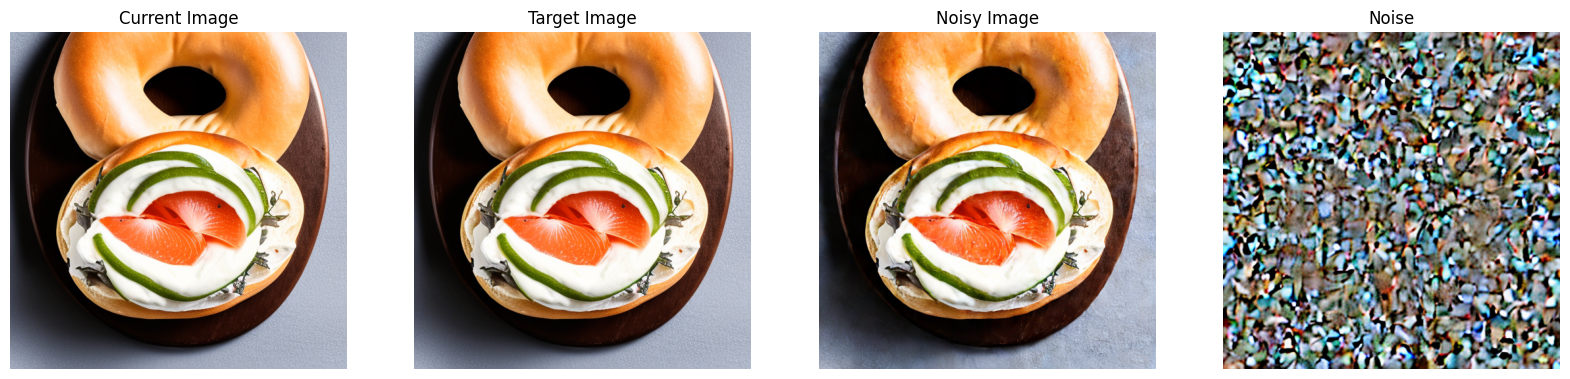

100%|██████████| 1001/1001 [02:11<00:00,  7.61it/s]

Optimizing process:


interactive(children=(IntSlider(value=1, description='index', max=200), Output()), _dom_classes=('widget-inter…

Output()

In [5]:
B = 1
lr = 1e-1
t_n_steps = 40

gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()
w, h = config['latent']['width'], config['latent']['height']


# Initialization
time = torch.tensor(B * [999], device=guidance.device)
init_noise = torch.randn(B, 4, h, w, device=guidance.device) * guidance.scheduler.init_noise_sigma
noise_pred, _, _ = guidance.predict_noise(
    init_noise,
    time,
    prompt_processor(),
    **batch,
    guidance_scale=config['guidance']['guidance_scale']
)
latents_denoised = guidance.get_x0(init_noise, noise_pred, time).detach()
latent = nn.Parameter(latents_denoised)

optimizer = torch.optim.Adam([latent], lr=lr, weight_decay=0)
num_steps = config['max_iters']
t_interval = n_iters // t_n_steps
img_array = []

try:
    for step in tqdm(range(num_steps + 1)):
        guidance.update_step(epoch=0, global_step=step)
        optimizer.zero_grad()

        if step % t_interval == 0:
            guidance_output = guidance(
                latent,
                prompt_processor(), **batch, test_info=True, rgb_as_latents=True,
                call_with_defined_noise=noise_pred
            )
        
        loss = 0.5 * F.mse_loss(latent, guidance_output['target_latent'].detach(), reduction="mean")
        loss.backward()
        optimizer.step()
        noise_pred = guidance_output["noise_pred"]
        
        if step % 5 == 0:
            rgb = guidance.decode_latents(latent).permute(0, 2, 3, 1)
            img_rgb = rgb.clamp(0, 1).detach().squeeze(0).cpu().numpy()

            fig, ax = plt.subplots(1, 4, figsize=(20, 5))
            ax[0].imshow(img_rgb)
            ax[1].imshow(guidance_output["target"].cpu().numpy())
            ax[2].imshow(guidance_output["noisy_img"].cpu().numpy())
            ax[3].imshow(guidance_output["noise_img"].cpu().numpy())
            ax[0].set_title('Current Image')
            ax[1].set_title('Target Image')
            ax[2].set_title('Noisy Image')
            ax[3].set_title('Noise')
            ax[0].axis('off')
            ax[1].axis('off')
            ax[2].axis('off')
            ax[3].axis('off')
            clear_output(wait=True)
            plt.show()
            img_array.append(figure2image(fig))
except KeyboardInterrupt:
    pass
finally:
    # browse the result
    print("Optimizing process:")
    images = img_array
    
    if len(images) > 0:
        # Set up the widgets
        slider = IntSlider(min=0, max=len(images)-1, step=1, value=1)
        output = Output()

        def display_image(index):
            with output:
                output.clear_output(wait=True)
                display(images[index])
        
        # Link the slider to the display function
        interact(display_image, index=slider)

        # Display the widgets
        # display(slider)
        display(output)

## 2. **DDIM inversion**
This is the same approach we use in 3D.

If the image gets updated in-between the SDI iterations, $\kappa_y^t$ from the previous method becomes invalid.
In this case, we can use DDIM inversion to estimate $\kappa_y^t$ from the previous image and the current image. This is the same approach we use in 3D.

*Use this method if the image gets updated or you need smaller LRs.*

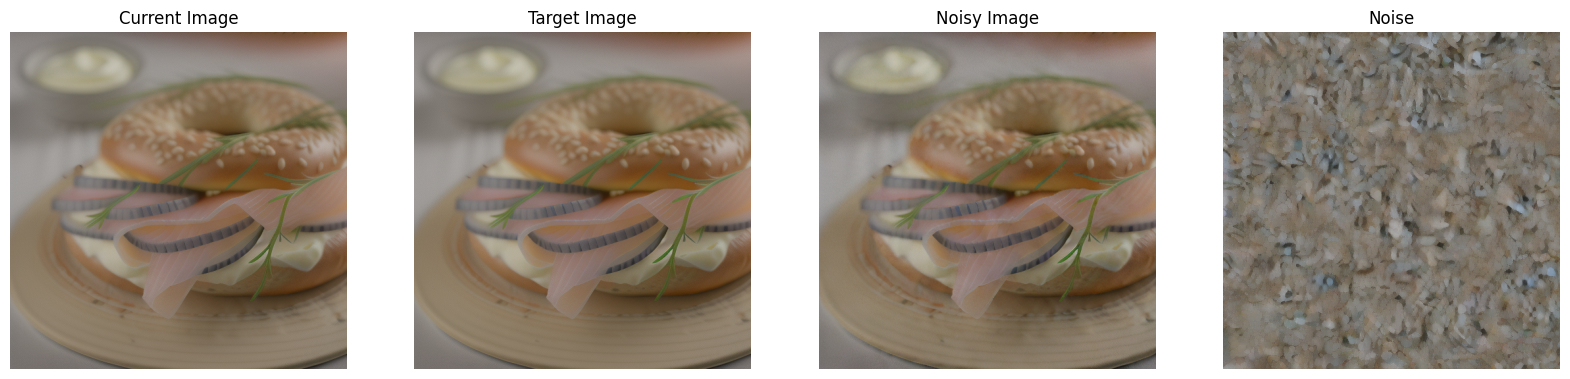

100%|██████████| 1001/1001 [02:25<00:00,  6.87it/s]

Optimizing process:


interactive(children=(IntSlider(value=1, description='index', max=200), Output()), _dom_classes=('widget-inter…

Output()

In [6]:
B = 1
lr = 1e-1
t_n_steps = 40

gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()
w, h = config['latent']['width'], config['latent']['height']

# Initialization
time = torch.tensor(B * [999], device=guidance.device)
init_noise = torch.randn(B, 4, h, w, device=guidance.device) * guidance.scheduler.init_noise_sigma
noise_pred, _, _ = guidance.predict_noise(
    init_noise,
    time,
    prompt_processor(),
    **batch,
    guidance_scale=config['guidance']['guidance_scale']
)
latents_denoised = guidance.get_x0(init_noise, noise_pred, time).detach()
latent = nn.Parameter(latents_denoised)

optimizer = torch.optim.Adam([latent], lr=lr, weight_decay=0)
num_steps = config['max_iters']
t_interval = n_iters // t_n_steps
img_array = []

try:
    for step in tqdm(range(num_steps + 1)):
        guidance.update_step(epoch=0, global_step=step)
        optimizer.zero_grad()

        if step % t_interval == 0:
            guidance_output = guidance(
                guidance.decode_latents(latent).permute(0, 2, 3, 1), # project through the decoder to regulirize the latents
                prompt_processor(), **batch, test_info=True # rgb_as_latents=True, 
            )
        
        loss = 0.5 * F.mse_loss(latent, guidance_output['target_latent'].detach(), reduction="mean")
        loss.backward()
        # guidance_output["loss_sdi"].backward()
        optimizer.step()
        noise_pred = guidance_output["noise_pred"]
        
        if step % 5 == 0:
            rgb = guidance.decode_latents(latent).permute(0, 2, 3, 1)
            img_rgb = rgb.clamp(0, 1).detach().squeeze(0).cpu().numpy()

            fig, ax = plt.subplots(1, 4, figsize=(20, 5))
            ax[0].imshow(img_rgb)
            ax[1].imshow(guidance_output["target"].cpu().numpy())
            ax[2].imshow(guidance_output["noisy_img"].cpu().numpy())
            ax[3].imshow(guidance_output["noise_img"].cpu().numpy())
            ax[0].set_title('Current Image')
            ax[1].set_title('Target Image')
            ax[2].set_title('Noisy Image')
            ax[3].set_title('Noise')
            ax[0].axis('off')
            ax[1].axis('off')
            ax[2].axis('off')
            ax[3].axis('off')
            clear_output(wait=True)
            plt.show()
            img_array.append(figure2image(fig))
except KeyboardInterrupt:
    pass
finally:
    # browse the result
    print("Optimizing process:")
    images = img_array
    
    if len(images) > 0:
        # Set up the widgets
        slider = IntSlider(min=0, max=len(images)-1, step=1, value=1)
        output = Output()

        def display_image(index):
            with output:
                output.clear_output(wait=True)
                display(images[index])
        
        # Link the slider to the display function
        interact(display_image, index=slider)

        # Display the widgets
        # display(slider)
        display(output)